<a href="https://colab.research.google.com/github/willdphan/fish-cnn/blob/main/Fish_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish Classifier CNN

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2020.
The [dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset) includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples. The CNN is trained to classifiy fish species based on provided images.

> ## Steps to CNN

>>[Import Libraries](#scrollTo=MZmKxZVWB3PW)

>>[Create List of Classes](#scrollTo=PqX8ze6JB3PZ)

>>[Transform into Pandas Dataset](#scrollTo=-2z-VVx1B3Pa)

>>[Create Transform Variable](#scrollTo=hdlCj0DnB3Pb)

>>[Convert Classes to Ints](#scrollTo=6K9UTng3B3Pb)

>>[Create Dataset Object](#scrollTo=SXvaTvH7B3Pb)

>>[Convert Pandas to PyTorch Dataset](#scrollTo=iU3k6cefB3Pb)

>>[Visualize Image](#scrollTo=vPejcr3HB3Pc)

>>[Set Hyperparameters](#scrollTo=q_tNxLsWB3Pc)

>>[Split Dataset](#scrollTo=K942cc5nB3Pc)

>>[Conv Net Class](#scrollTo=vNxhTzSzB3Pc)

>>[Train Model](#scrollTo=yfksNvvXB3Pd)



### Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import os

# PyTorch
import PIL
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# matplotlib
from matplotlib import pyplot as plt

from torch.autograd import Variable

In [ ]:
# yields a tuple containing the directory path, a list of subdirectories in that path, and a list of filenames in that path
for dirname, _, filenames in os.walk('/kaggle/input/'):
    # iterates over the list of filenames obtained from os.walk.
    # each filename represents a file within the current directory.
    for filename in filenames:
        # for each file concatenate directory file path with file name
        os.path.join(dirname, filename)

print("Directory Path: " + os.getcwd())

Directory Path: /kaggle/working


### Create List of Classes

Since this dataset doesn't follow the `torchvision.dataset.ImagesFolder` [structure](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder****) we cannot use the abstraction for an easy data exportation. Instead I will use the same methods of [this notebook](https://www.kaggle.com/tuqayabdullazade/fish-species-classification-99-2-accuracy) by [Tugay Abdullazade](https://www.kaggle.com/tuqayabdullazade/fish-species-classification-99-2-accuracy) to first create a pandas dataframe and then create a PyTorch dataset.


In [ ]:
data_dir = """../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"""

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:           # Removes .txt and segmentation script
        classes.append(directory)

print(classes)

['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


`image_classes` is an array that represents the classes of the images. It creates an array with a shape of (9000,), meaning it has 9000 elements. Each element corresponds to a class label. The array is created by repeating each class label 1000 times and then reshaping it into a 1D array.

In [ ]:
# empty list to store path of images
image_paths = []
# array is created by repeating each class label 1000 times and then reshaping it into a 1D array.
image_classes = np.array([[cls]*1000 for cls in classes]).reshape(-1) # create a classes array of shape (9000,)

for cls in classes:
    # data_dir is var that represents the directory where the images are stored
    # cls is the current class being processed in the loop
    # os.listdir is a function that returns a list of filenames in a directory
    # os.path.join to construct the path to the current class directory (data_dir/cls/cls) and then retrieves the list of filenames within that directory.
    # For each filename i, code uses another os.path.join to combine the class directory path with the filename, resulting in the complete image path.
    # extend() method appends all the elements from the generator expression to the image_paths list.
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in os.listdir(os.path.join(data_dir, cls, cls)))

### Transform into Pandas Dataset

Here we adds the path of the image to the first column, and the image class to the second column.

In [ ]:
data = pd.DataFrame({'path':image_paths, 'class':image_classes, })

print(data)

                                                   path            class
0     ../input/a-large-scale-fish-dataset/Fish_Datas...  Hourse Mackerel
1     ../input/a-large-scale-fish-dataset/Fish_Datas...  Hourse Mackerel
2     ../input/a-large-scale-fish-dataset/Fish_Datas...  Hourse Mackerel
3     ../input/a-large-scale-fish-dataset/Fish_Datas...  Hourse Mackerel
4     ../input/a-large-scale-fish-dataset/Fish_Datas...  Hourse Mackerel
...                                                 ...              ...
8995  ../input/a-large-scale-fish-dataset/Fish_Datas...    Red Sea Bream
8996  ../input/a-large-scale-fish-dataset/Fish_Datas...    Red Sea Bream
8997  ../input/a-large-scale-fish-dataset/Fish_Datas...    Red Sea Bream
8998  ../input/a-large-scale-fish-dataset/Fish_Datas...    Red Sea Bream
8999  ../input/a-large-scale-fish-dataset/Fish_Datas...    Red Sea Bream

[9000 rows x 2 columns]


### Create Transform Variable

In [ ]:
# Those are the transformations we will apply in our dataset
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
    ])

### Convert Classes to Ints

In [ ]:
str_to_int = {
 'Hourse Mackerel': 0,
 'Black Sea Sprat': 1,
 'Sea Bass': 2,
 'Red Mullet': 3,
 'Trout': 4,
 'Striped Red Mullet': 5,
 'Shrimp': 6,
 'Gilt-Head Bream': 7,
 'Red Sea Bream': 8
}

### Create Dataset Object

Class the retrieves the data, root directory, and performs the necessary transformations.

In [ ]:
# Create the Torch Dataset object for our pandas dataframe
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(str_to_int[self.data.iloc[idx, 1]])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

### Convert Pandas to PyTorch Dataset

In [ ]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

### Visualize Image

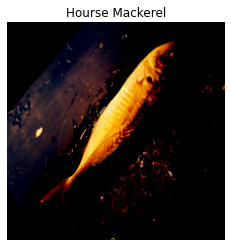

In [ ]:
img, lab = dataset[42]
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(classes[int(lab)])
plt.axis('off')
plt.show()

### Set Hyperparameters

In [ ]:
loss_nn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 20

### Split Dataset

Split dataset into Train, Test. Set `batch_size` to 20.

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [8000,1000])
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [ ]:
# a is the next batch of data in the train_loader
a = next(iter(train_loader))
# get the batch size, as you can see - it's 20
a[0].size()

torch.Size([20, 3, 224, 224])

### Conv Net Class

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()
        self.out_dim = out_dim

        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU()
        )

        self.q1 = nn.Linear(22*22*32, 64) # The 22*22 are the final dimensions of the "image"
        self.q2 = nn.Linear(64, out_dim)

    def forward(self, x):
        conv = self.convs(x)
        flat = conv.reshape(-1, 22*22*32)
        q1 = F.relu(self.q1(flat))
        q = self.q2(q1)
        return q

In [ ]:
# dataset[0] retrieves the first sample from the dataset. dataset[0][0] retrieves the input data of the first sample.
input_dim = dataset[0][0].shape[0] # Number of channels in the image (3)
output_dim = len(classes) # Number of classes (9)

model = CNN(input_dim, output_dim).to(device)

learning_rate = 3e-4
optimizer_nn = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train Model

In [ ]:
iterations = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(batch_size, 3, 224, 224))
        labels = Variable(labels)

        outputs = model(train)
        loss = loss_nn(outputs, labels)

        predictions = torch.max(outputs, 1)[1].to(device)

        optimizer_nn.zero_grad()

        loss.backward()

        optimizer_nn.step()

        iterations += 1

        if iterations % 50 == 0:
            corrects = 0
            total = 0

            for images, labels in test_loader:

                images, labels = images.to(device), labels.to(device)

                test = Variable(images.view(batch_size, 3, 224, 224))

                outputs = model(test)

                predict = torch.max(outputs.data, 1)[1].to(device)

                total += len(labels)

                corrects += (predict == labels).sum()

            acuracy = 100 * corrects / float(total)

            loss_list.append(loss.data)
            iteration_list.append(iterations)

    print(f"Epoch: {epoch+1} | Loss: {loss.data} | Acuracy: {acuracy}")


Epoch: 1 | Loss: 0.9105364084243774 | Acuracy: 70.5
Epoch: 2 | Loss: 0.14410369098186493 | Acuracy: 85.00000762939453
Epoch: 3 | Loss: 0.3561481833457947 | Acuracy: 89.50000762939453
Epoch: 4 | Loss: 0.04217186197638512 | Acuracy: 91.70000457763672
Epoch: 5 | Loss: 0.09716402739286423 | Acuracy: 93.60000610351562
Epoch: 6 | Loss: 0.02697291411459446 | Acuracy: 92.9000015258789
Epoch: 7 | Loss: 0.01780235394835472 | Acuracy: 94.00000762939453
Epoch: 8 | Loss: 0.07411397993564606 | Acuracy: 93.30000305175781
Epoch: 9 | Loss: 0.023183178156614304 | Acuracy: 92.60000610351562
Epoch: 10 | Loss: 0.003580890130251646 | Acuracy: 96.30000305175781


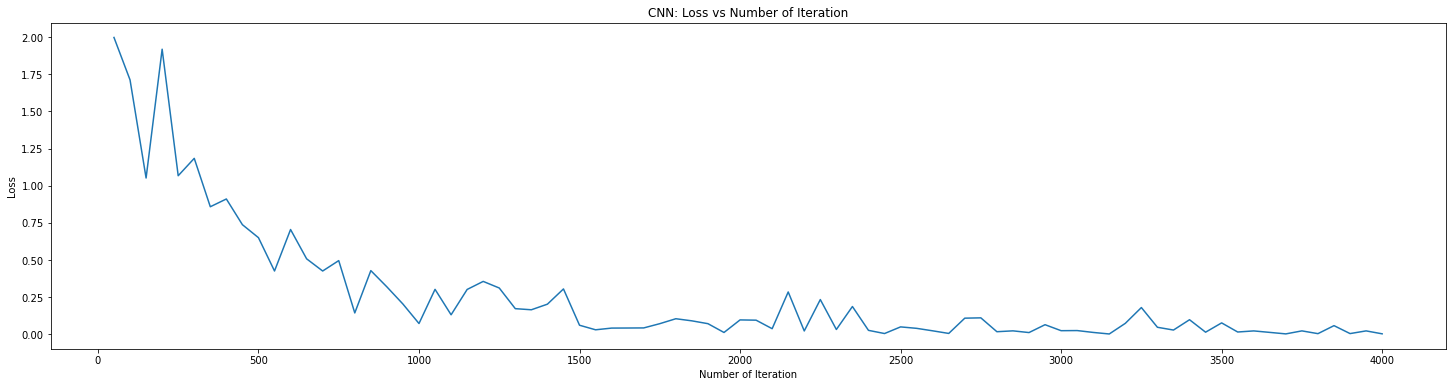

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of Iteration")
plt.show()

In [ ]:
def prediction(index, data):
    img, _ = data[index]
    img = img.to(device)
    img = Variable(img.view([-1, 3, 224, 224]))
    outputs = model(img)
    predict = torch.max(outputs.data, 1)[1].to(device)

    return classes[int(predict)]

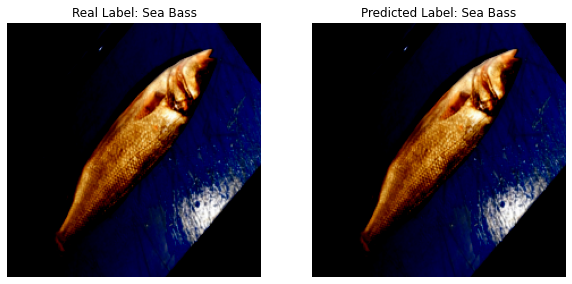

In [ ]:
index = 2048

fig = plt.figure(figsize=(10, 7))

img, label = dataset[index]
predicted_label = prediction(index, dataset)

fig.add_subplot(1, 2, 1)
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Real Label: " + classes[int(label)])

fig.add_subplot(1,2,2)
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Predicted Label: " + predicted_label)

plt.show()